In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, recall_score, f1_score, 
                             confusion_matrix, precision_score, roc_auc_score,
                             classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler


In [4]:
plt.style.use('ggplot')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 50)
nlp = spacy.load('en_core_web_sm')

In [5]:
#%% Data Loading & Initial Inspection
df = pd.read_csv('fake_job_postings.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
display(df.head())

Dataset Shape: (17880, 18)

First 5 Rows:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


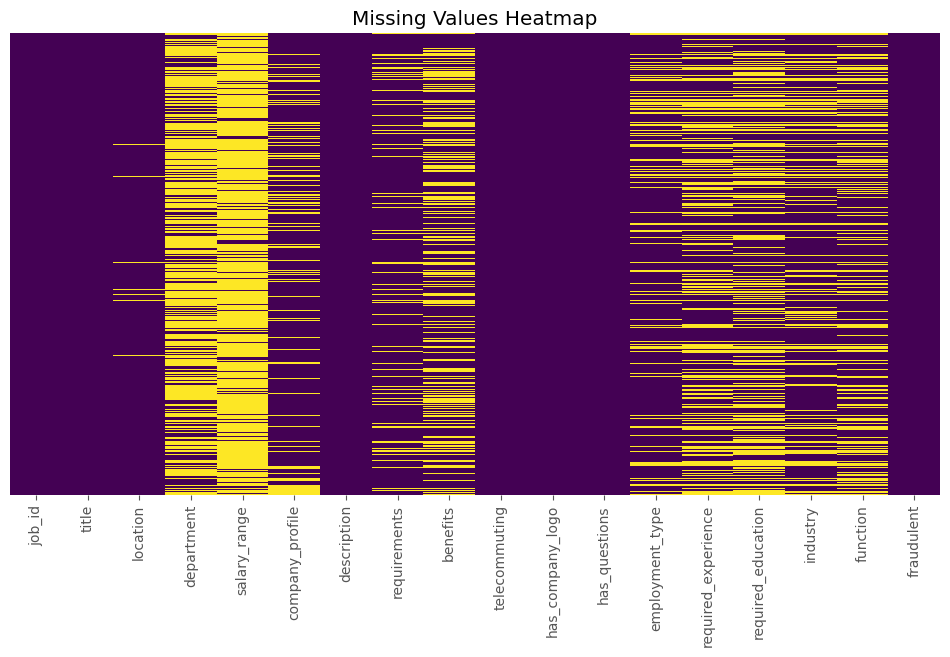

In [6]:
# Missing Data Analysis
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

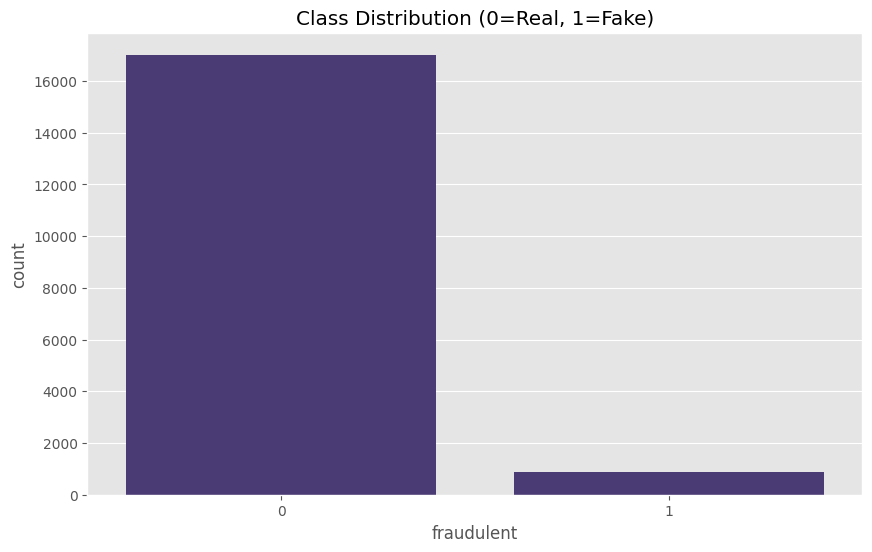

In [7]:
# Target Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='fraudulent', data=df)
plt.title('Class Distribution (0=Real, 1=Fake)')
plt.show()

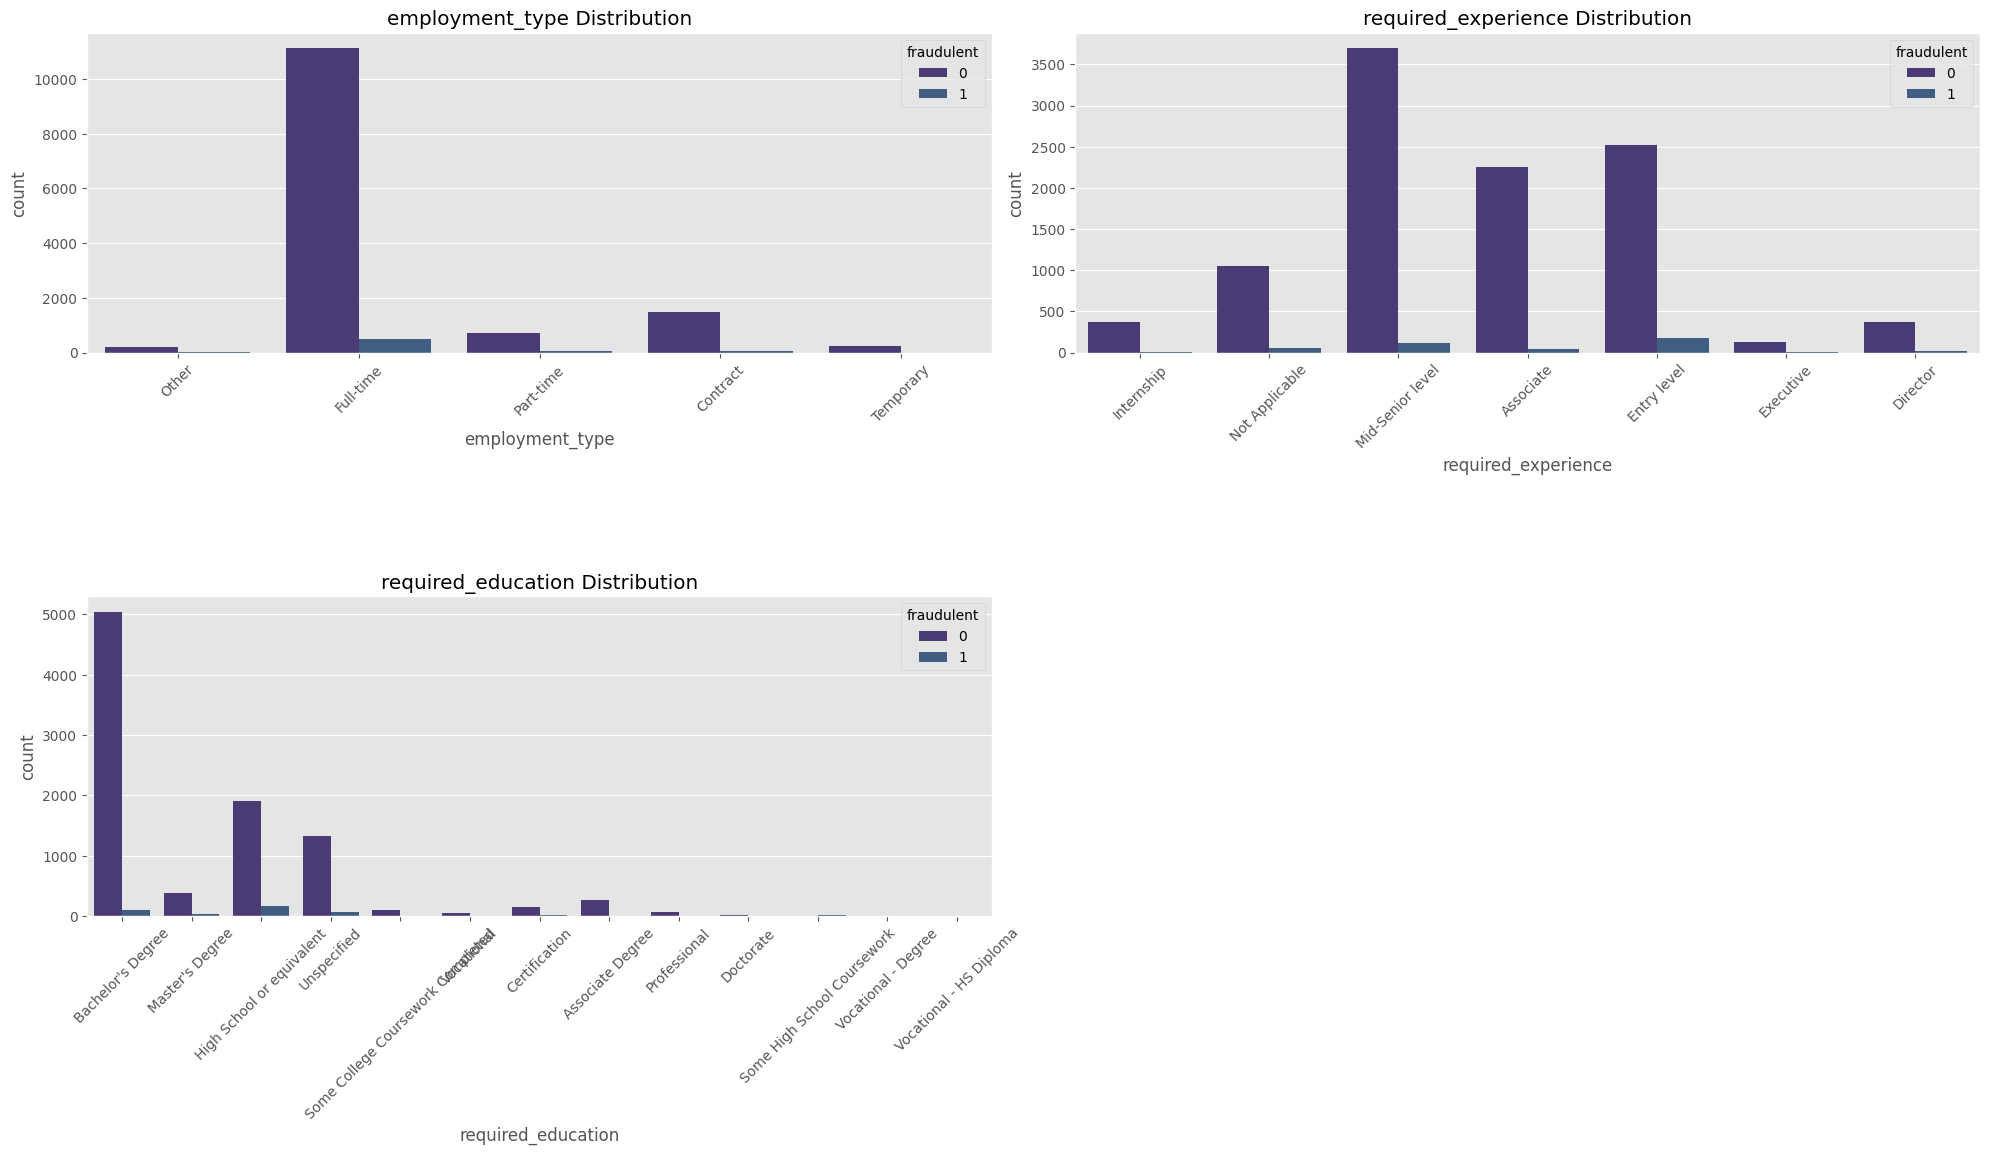

In [8]:
# Categorical Features Analysis
cat_cols = ['employment_type', 'required_experience', 'required_education']
plt.figure(figsize=(20,15))
for i,col in enumerate(cat_cols,1):
    plt.subplot(3,2,i)
    sns.countplot(x=col, data=df, hue='fraudulent')
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

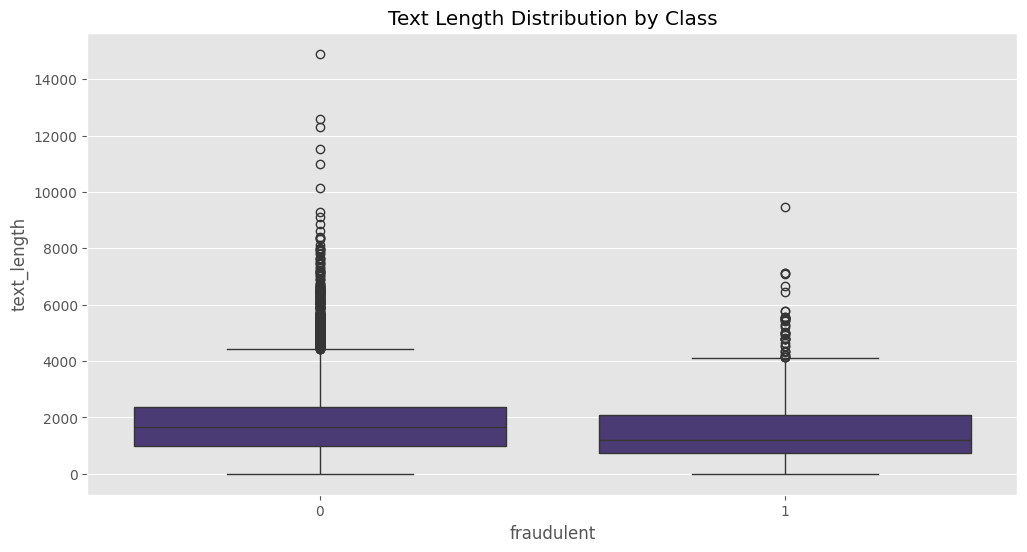

In [9]:
# Text Length Analysis
df['description'] = df['description'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['text'] = df['description'] + ' ' + df['requirements']
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
sns.boxplot(x='fraudulent', y='text_length', data=df)
plt.title('Text Length Distribution by Class')
plt.show()

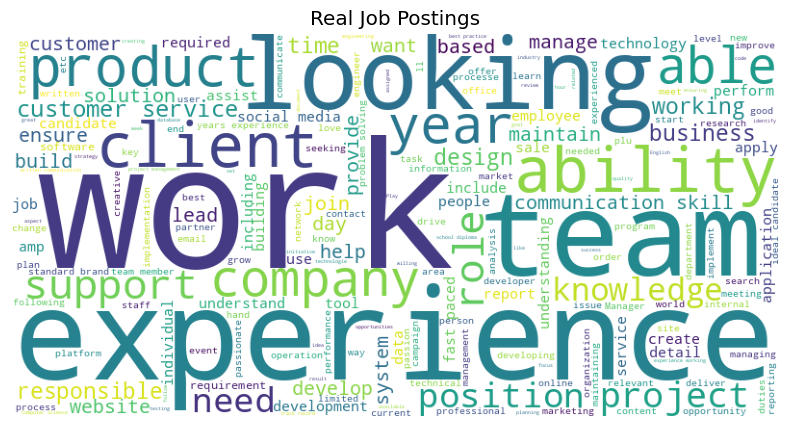

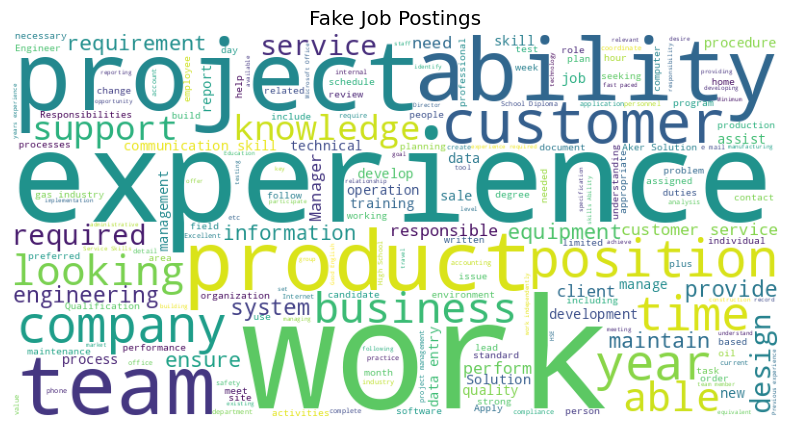

In [10]:
# Word Clouds
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, 
                   background_color='white', 
                   stopwords=STOP_WORDS).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

real_text = ' '.join(df[df['fraudulent']==0]['text'].dropna())
fake_text = ' '.join(df[df['fraudulent']==1]['text'].dropna())
plot_wordcloud(real_text, 'Real Job Postings')
plot_wordcloud(fake_text, 'Fake Job Postings')

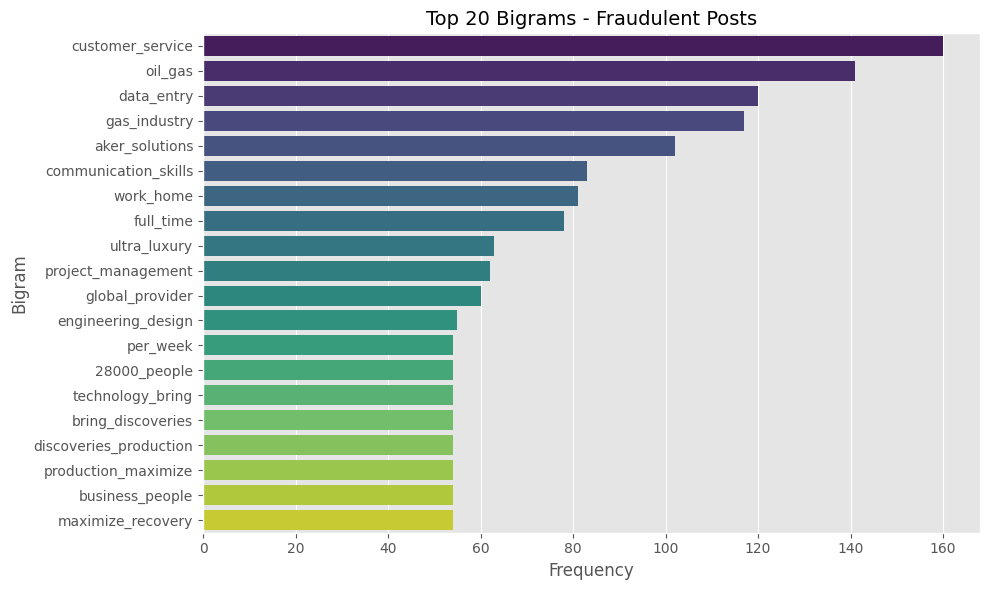

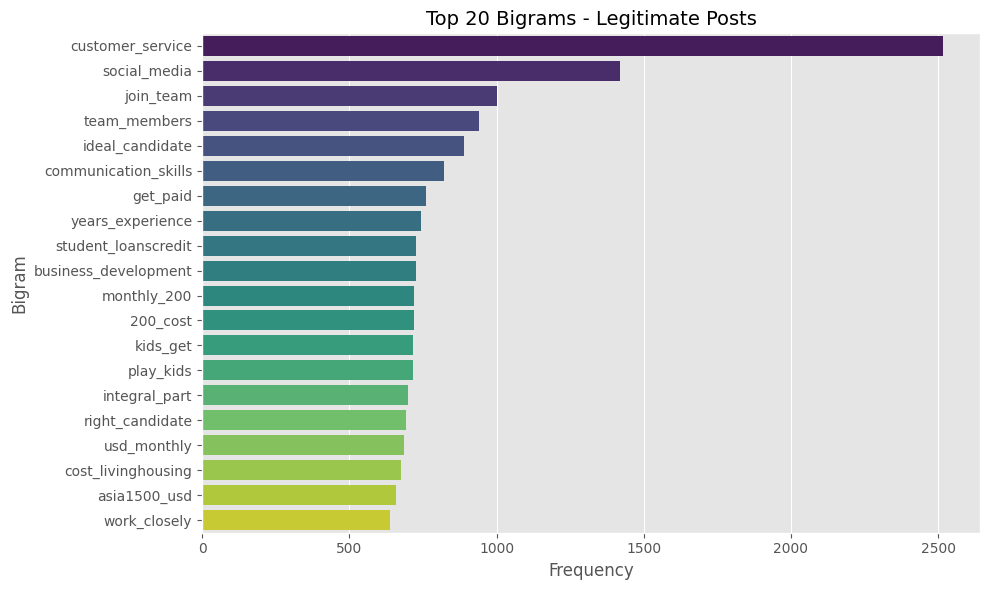

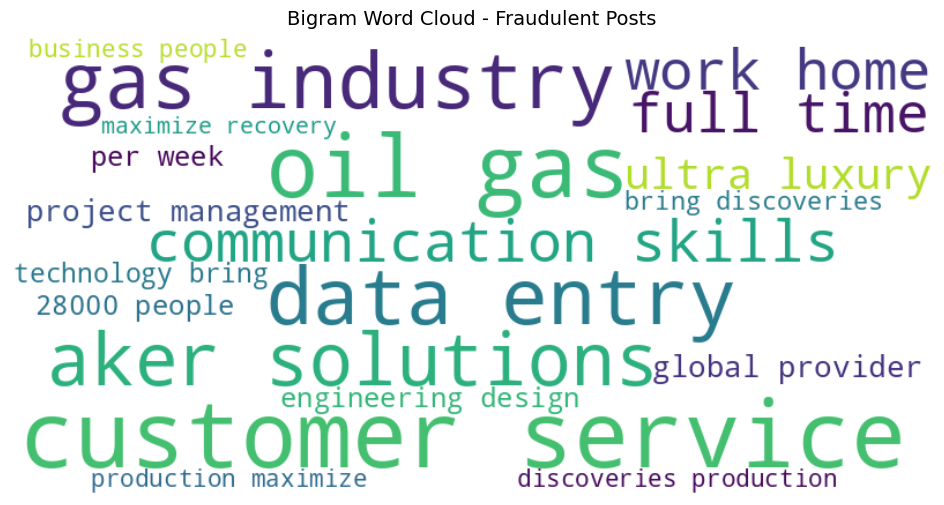

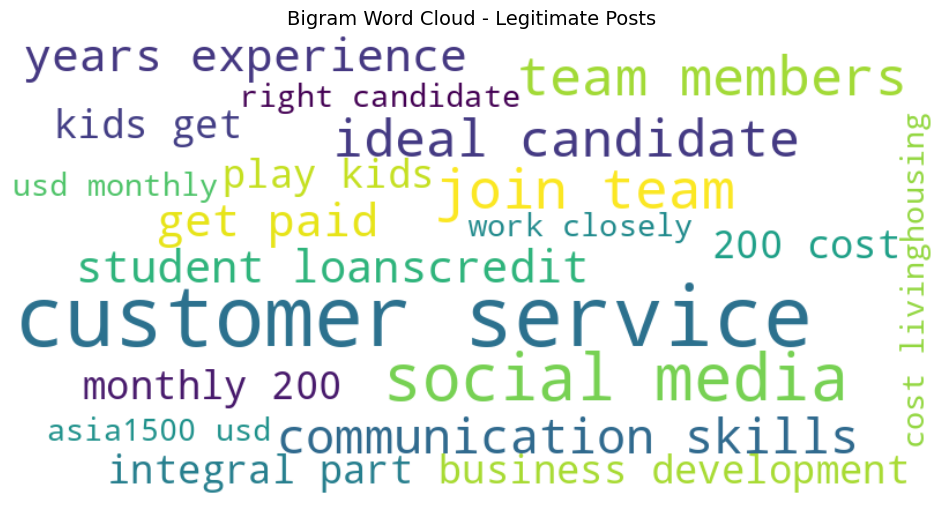

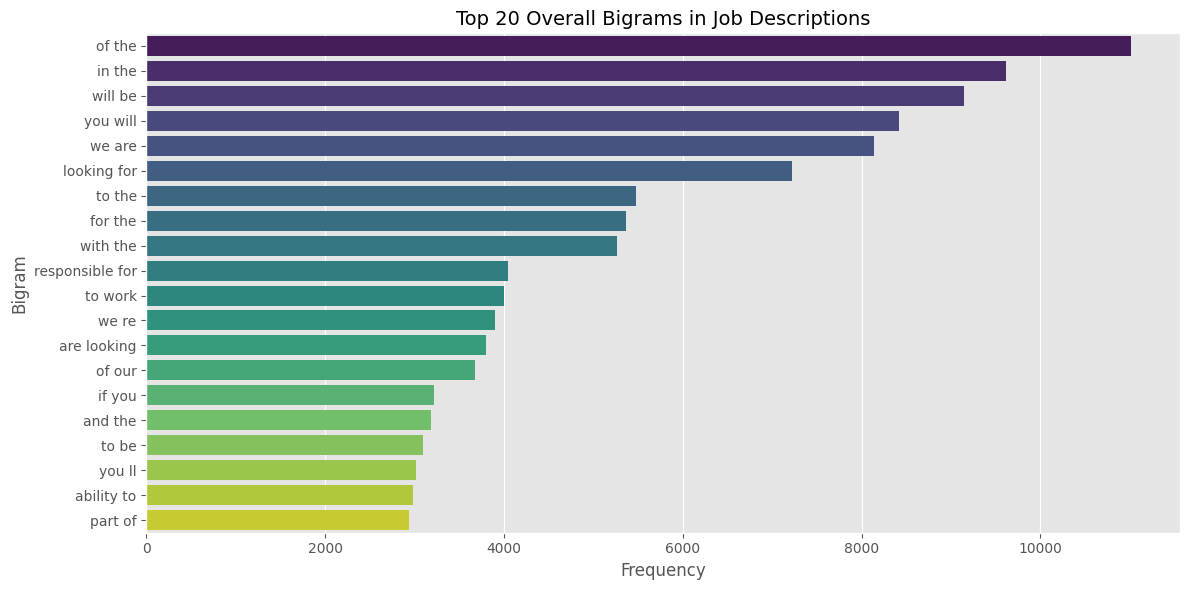

In [13]:
#%% Bigram Analysis Section

def preprocess_text(text):
    """Clean text data for n-gram analysis"""
    if pd.isna(text):
        return ''
    # Lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Apply preprocessing to job descriptions
df['clean_tokens'] = df['description'].apply(preprocess_text)

# Generate bigrams for each document
df['bigrams'] = df['clean_tokens'].apply(lambda x: list(nltk.bigrams(x)))

# Function to analyze bigrams by class
def analyze_bigrams_by_class(class_label):
    """Analyze bigram frequencies for a specific class"""
    all_bigrams = []
    for bg_list in df[df['fraudulent'] == class_label]['bigrams']:
        all_bigrams.extend(bg_list)
    bigram_freq = nltk.FreqDist(all_bigrams)
    return pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['count']).sort_values('count', ascending=False)

# Get top bigrams for fraudulent and legitimate posts
fraud_bigrams = analyze_bigrams_by_class(1).head(20)
legit_bigrams = analyze_bigrams_by_class(0).head(20)

#%% Bigram Visualization

#%% Updated Bigram Visualization with Hue Assignment

def plot_bigram_freq(df_bigrams, title):
    """Plot top bigrams frequency distribution with proper hue handling"""
    plt.figure(figsize=(10,6))
    
    # Create formatted bigram strings
    df_plot = df_bigrams.reset_index()
    df_plot['bigram_str'] = df_plot['index'].map('_'.join)
    
    ax = sns.barplot(
        x='count', 
        y='bigram_str',
        hue='bigram_str',  # Assign hue to same variable as y
        data=df_plot,
        palette='viridis',
        legend=False  # Disable redundant legend
    )
    
    plt.title(f'Top 20 Bigrams - {title}', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Bigram', fontsize=12)
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_bigram_freq(fraud_bigrams, 'Fraudulent Posts')
plot_bigram_freq(legit_bigrams, 'Legitimate Posts')


#%% Bigram Word Clouds

def generate_bigram_wordcloud(bigram_freq, title):
    """Generate word cloud from bigram frequencies"""
    bigram_dict = {' '.join(k): v for k, v in bigram_freq.to_dict()['count'].items()}
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='viridis').generate_from_frequencies(bigram_dict)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Bigram Word Cloud - {title}', fontsize=14)
    plt.axis('off')
    plt.show()

generate_bigram_wordcloud(fraud_bigrams, 'Fraudulent Posts')
generate_bigram_wordcloud(legit_bigrams, 'Legitimate Posts')

#%% Updated Advanced Bigram Analysis using CountVectorizer

# Create bigram vectorizer and transform data
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50)
bigram_matrix = bigram_vectorizer.fit_transform(df['description'].fillna(''))

# Prepare visualization data
bigram_counts = pd.DataFrame({
    'bigram': bigram_vectorizer.get_feature_names_out(),
    'count': np.asarray(bigram_matrix.sum(axis=0)).flatten()
}).sort_values('count', ascending=False).head(20)

# Plot overall bigram distribution with proper hue assignment
plt.figure(figsize=(12,6))
sns.barplot(
    x='count',
    y='bigram',
    hue='bigram',  # Assign hue to same variable as y
    data=bigram_counts,
    palette='viridis',
    legend=False  # Disable redundant legend
)
plt.title('Top 20 Overall Bigrams in Job Descriptions', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bigram', fontsize=12)
plt.tight_layout()
plt.show()



In [11]:
#%% Data Preprocessing
# Handle Missing Values
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna(' ')
df['text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)


In [ ]:
# Text Cleaning Pipeline
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Lemmatization with SpaCy
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Apply Cleaning
df['clean_text'] = df['text'].apply(clean_text).apply(lemmatize)


In [ ]:
#%% Feature Engineering
# POS Tagging
def get_pos_tags(text):
    doc = nlp(text)
    return ' '.join([token.pos_ for token in doc])

df['pos_tags'] = df['clean_text'].apply(get_pos_tags)

# Text Length Features
df['char_count'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))



In [ ]:
#%% Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df[['clean_text', 'pos_tags', 'char_count', 'word_count']], 
                                df['fraudulent'])

In [ ]:
#%% Prepare Data for Modeling
# Combine Features
X = X_res['clean_text'] + ' ' + X_res['pos_tags']
y = y_res

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


In [ ]:
#%% Model Building Pipeline
models = [
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('SVC', SVC(class_weight='balanced')),
    ('RF', RandomForestClassifier(class_weight='balanced')),
    ('NB', MultinomialNB())
]

results = []
for name, model in models:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
        ('clf', model)
    ])
    
    # Cross-Validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    
    # Full Training
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Store Results
    results.append({
        'Model': name,
        'CV Mean F1': np.mean(cv_scores),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred)
    })

In [ ]:
#%% Model Evaluation
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Performance Comparison:")
display(results_df.sort_values('Test F1', ascending=False))

# Best Model Analysis
best_model = results_df.loc[results_df['Test F1'].idxmax()]
print(f"\nBest Model: {best_model.name}")

# Confusion Matrix for Best Model
best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', eval(best_model.name)())
])
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))